In [9]:

"""
Task 2: Data Visualisation
1. a.
"""
from time import sleep
from kafka3 import KafkaConsumer
import datetime as dt
import matplotlib.pyplot as plt

# this line is needed for the inline display of graphs in Jupyter Notebook
%matplotlib notebook
topic = 'Producer1'
hostip = "10.192.33.112"



def annotate_max(x,y,ax = None):
    ymax = max(y)
    xpos = y.index(ymax)
    xmax = x[xpos]
    text = 'Max: Time={}, Value={}'.format(xmax, ymax)
    if not ax:
        ax = plt.gca()                                       # arrow position in plot
    ax.annotate(text, xy=(xmax, ymax), xytext=(xmax,ymax+5), arrowprops=dict(facecolor='red', shrink=0.02),)

def annotate_min(x,y,ax = None):
    ymin = min(y)
    xpos = y.index(ymin)
    xmin = x[xpos]
    text = 'Min: Time={}, Value={}'.format(xmin, ymin)
    if not ax:
        
        #plot in the figure
        ax = plt.gca()                                       # arrow position in plot
    ax.annotate(text, xy=(xmin, ymin), xytext=(xmin,ymin-5), arrowprops=dict(facecolor='blue', shrink=0.02),)


def connect_kafka_consumer():
    consumer = None
    try:
        consumer = KafkaConsumer(topic,
                                consumer_timeout_ms=10000,
                                bootstrap_servers=[f'{hostip}:9092'],
                                api_version=(0,10))
    except Exception as ex:
        print('Exception while connecting Kafka')
        print(str(ex))
    finally:
        return consumer



def init_plots():
    try:
        width = 9.5
        height = 6
        fig = plt.figure(figsize=(width, height))
        #adding subplot to figure
        #The argument 111 is a 3-digit integer where the first digit represents the 
        #number of rows, the second digit represents the number of columns, and the 
        #third digit represents the index of the subplot.
        ax = fig.add_subplot(111)
        fig.suptitle('Climate Streaming with Max, Min values')
        ax.set_xlabel('Arrival Time')
        ax.set_ylabel('Air Temperature')
        #         ax.set_ylim(0,110)
        #displace figure
        fig.show()
        #draw the canvas
        fig.canvas.draw()
        return fig, ax
    
    except Exception as ex:
        print("init_plots")
        print(str(ex))



<IPython.core.display.Javascript object>


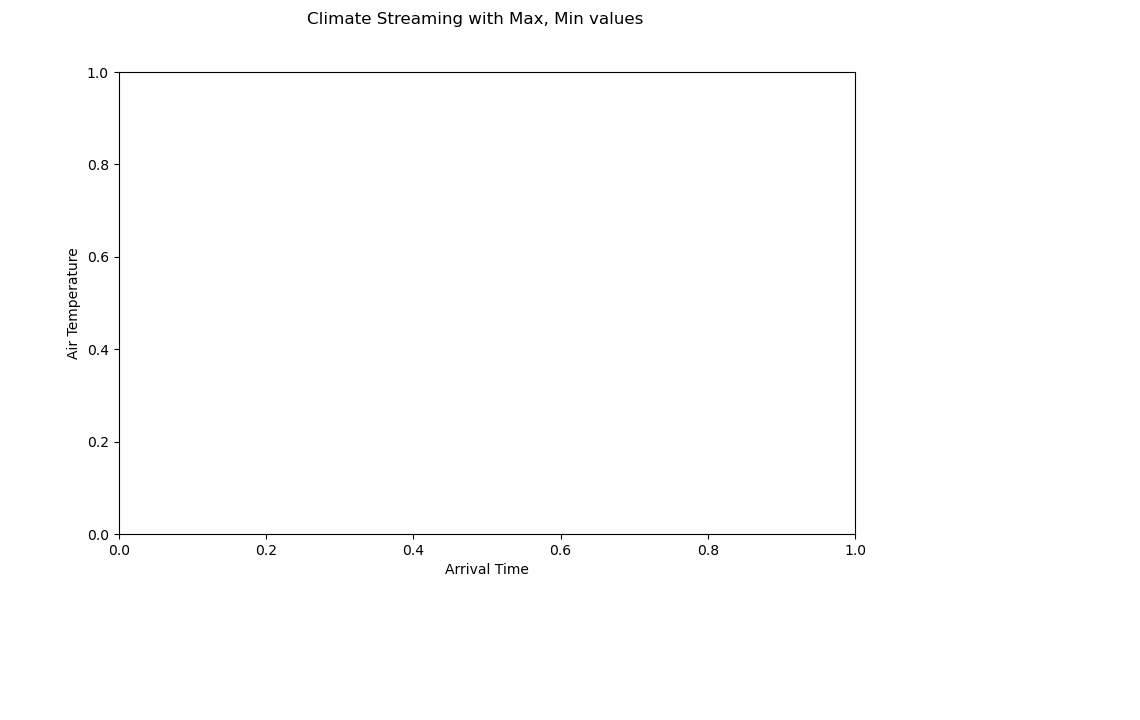

24


/tmp/ipykernel_4660/2698804919.py:37: MatplotlibDeprecationWarning: The close_event function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use callbacks.process('close_event', CloseEvent(...)) instead.
  plt.close('all')


In [13]:
from matplotlib.backend_bases import CloseEvent
def consume_msg(consumer, fig, ax):
    try:
        x, y = [], []
        for msg in consumer:

            #get the value attribute from consumer object
            #which dataframe in byte, then decode it with 'utf-8' into JSON string
            #then split into each field/column
            data = str(msg.value.decode('utf-8')).split(',')
            #print(data)
            air_temp_key_value = data[2]
    #         print(air_temp_tuple) #split into key: value pair
            air_temp_key_value = air_temp_key_value.split(':')
            air_temp_value = int(air_temp_key_value[1])
            print(air_temp_value)
            y.append(int(air_temp_value))

            #arrival time
            # %X' is the format code for the locale’s appropriate time representation.
            x.append(dt.datetime.now().strftime('%X'))
            #print(x)

            # start plotting when at least 10 data points
            if len(y) > 10:
                #need to clear time to repaint to refresh the new data
                ax.clear()
                ax.plot(x,y)
                ax.set_xlabel('Time')
                ax.set_ylabel('Value')
                annotate_max(x,y,ax)
                annotate_min(x,y,ax)
                fig.canvas.draw()
                #pop the oldest value
                x.pop(0)
                y.pop(0)
        plt.close('all')
    except Exception as e:
        print(f"Error: {e}")

        
    # Replace plt.close('all') with the following:
    #CloseEvent constructor
    #close to avoid multiple canvas show
    #fig.canvas.callbacks.process('close_event', CloseEvent(fig.canvas))
            
#     except Exception as ex:
#         print("consume_msg")
#         print(str(ex))
        
if __name__ == '__main__':
    consumer = connect_kafka_consumer()
    fig, ax = init_plots()
    consume_msg(consumer,fig, ax)

In [35]:
import folium

# Initialize the map with a specific location and zoom level
fomap = folium.Map(location=[-37.812015244225677, 144.951471202974], zoom_start=15)

# Define the tooltip text
tooltip = 'Click me!'

# Create a marker with the tooltip
folium.Marker(
    location=[-37.812015244225677, 144.951471202974],
    popup='I am a popup',
    tooltip=tooltip
).add_to(fomap)

# Display the map
fomap


In [25]:
from pymongo import MongoClient
host_ip = "10.192.33.112" 

mongo_client = MongoClient(host_ip, 27017)
db = mongo_client['fit3182_assignment_db']
collection = db.a2_partB



# Preparing the data for plotting
fires = []
# Looping through all the data
for row in collection.find():
    fires.append(row)

    

In [36]:
import folium

In [37]:
# Melbourn locaiton
fomap = folium.Map(location=[-37.812015244225677, 144.951471202974], zoom_start=15)#zoom ratio

In [44]:
#visualisation
for fire in fires:
    #print(fire)
    marker_colour = 'blue' if fire['fire_cause'] == 'natural' else 'red'
    
    # Create tooltip 
    #use double quote since single quote used
    #just a formate string for popup show when click to the marker
    tooltip = f"Air Temp: {fire['air_temperature_celcius']} °C, Humidity: {fire['relative_humidity']}, knots: {fire['windspeed_knots']}, MaxWindSpeed {fire['max_wind_speed']}, precipitation {fire['precipitation']}, GHI_w/m2: {fire['GHI_w/m2']}, date: {fire['date']}"
    
    #print((fire['latitude'], fire['longitude']))
    folium.Marker(
        location=[fire['latitude'], fire['longitude']],
        popup=folium.Popup(tooltip, max_width=450),
        icon=folium.Icon(color=marker_colour)).add_to(fomap) 
fomap